# Lab 2 - AD HW
We are implementing image augmentation on the SimpleNN model.


In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.simplefilter("ignore", UserWarning)


In [ ]:
USE_COLAB = True

In [ ]:
if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if USE_COLAB:
    %cd /content/drive/MyDrive/DNN Final Project/SemiSupervisedBenchmarking/RotNet

/content/drive/MyDrive/DNN Final Project/SemiSupervisedBenchmarking/RotNet


In [ ]:
# Residual Network 20 (ResNet20)
# input is nx3x32x32, output is nx10

# Residual Block
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=inplanes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        if inplanes > planes or stride > 1:
            # Option B
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=inplanes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    padding=0,
                    bias=False,
                ),
                nn.BatchNorm2d(planes),
            )
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity if self.downsample is None else self.downsample(identity)
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv0 = nn.Conv2d(
            in_channels=3,
            out_channels=self.inplanes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn0 = nn.BatchNorm2d(self.inplanes)
        self.layer1 = self._make_layer(block, planes=16, blocks=layers[0], stride=1)
        self.layer2 = self._make_layer(block, planes=32, blocks=layers[1], stride=2)
        self.layer3 = self._make_layer(block, planes=64, blocks=layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=64, out_features=num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        layers = []
        for i in range(blocks):
            layers.append(
                block(
                    inplanes=(self.inplanes if i == 0 else planes),
                    planes=planes,
                    stride=stride if i == 0 else 1,
                )
            )
        self.inplanes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load data with transformations

In [ ]:
from dataloader import DataLoader, GenericDataset

train_set = GenericDataset(
    dataset_name='cifar10',
    split= 'train',
    random_sized_crop=False,
    num_imgs_per_cat=50)
val_set = GenericDataset(
    dataset_name='cifar10',
    split='test',
    random_sized_crop=False)

train_loader = DataLoader(
    dataset=train_set,
    batch_size=128,
    unsupervised=False,
    epoch_size=10*5000,
    num_workers=4,
    shuffle=True)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=128,
    unsupervised=False,
    epoch_size=None,
    num_workers=4,
    shuffle=False)

############################################

Files already downloaded and verified
num_imgs_per_category 50
Files already downloaded and verified


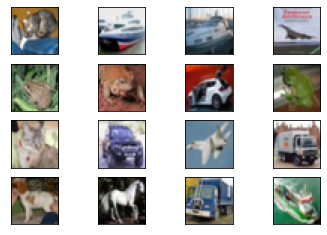

In [ ]:
from matplotlib import pyplot as plt
for batch_idx, (inputs, targets) in enumerate(val_loader(0)):
  inv_transform = val_loader.inv_transform
  for i in range(16):
    plt.subplot(4,4,i+1)
    fig=plt.imshow(inv_transform(inputs[i]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.show()
  break

### Instantiate SimpleNN model and deploy it to GPU devices.

In [ ]:
# specify the device for computation
#############################################
# your code here
if torch.cuda.is_available():  # check if NVIDIA GPU is available
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():  # check if Apple's Metal is available
    device = torch.device("mps")
    print(
        f"Checking pytorch is built with mps activated: {torch.backends.mps.is_built()}"
    )
else:
    device = torch.device("cpu")

if device == torch.device("cuda:0") or device == torch.device("mps"):
    print(f"Running on {device} GPU...")
else:
    print("Running on CPU...")

# instantiate the model on device
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model_resnet"
# load the best model checkpoint and continue training
print("==> Loading the best model checkpoint ...")
checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, "resnet.pth"))

model = ResNet(BasicBlock, [3, 3, 3])

model.load_state_dict(checkpoint["state_dict"])

for name, param in model.named_parameters():
  if ('fc' in name) or ('layer3.0.conv' in name) or ('layer3.1.conv' in name) or ('layer3.2.conv' in name): # or 'layer2.0.conv' or 'layer2.1.conv' or'layer2.2.conv' 
    print(name)
    param.requires_grad = True
  else:
    param.requires_grad = False


num_classes = model.fc.in_features
model.fc = nn.Linear(num_classes, 10)

model.to(device)

#############################################

Running on cuda:0 GPU...
==> Loading the best model checkpoint ...
layer3.0.conv1.weight
layer3.0.conv2.weight
layer3.1.conv1.weight
layer3.1.conv2.weight
layer3.2.conv1.weight
layer3.2.conv2.weight
fc.weight
fc.bias


ResNet(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Set up the loss function and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.08

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-3

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(
    params=model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM,nesterov = True, weight_decay=REG
)
#############################################

### Train model

In [ ]:
# some hyperparameters
# total number of training epochs
from http.cookiejar import DefaultCookiePolicy
import pickle  # for saving accuracy and loss

EPOCHS = 60

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model_resnet"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

# BONUS: hyperparams for learning rate scheduler
DECAY_EPOCHS = [5,15, 40]
DECAY = 0.2

avg_train_acc = []
avg_train_loss = []
avg_val_acc = []
avg_val_loss = []

In [ ]:
print("==> Training starts!")
print("=" * 50)


for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    # BONUS
    if i in DECAY_EPOCHS and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    model.train()

    #######################

    print("Epoch %d:" % i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0  # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader(0)):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)

        # compute the output and loss
        outputs = model(inputs)
        targets = targets.to(device)  # don't forget to also copy targets to device
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        _, preds = outputs.max(1)
        total_examples += targets.shape[0]
        correct_examples += preds.eq(targets).sum().item()
        # track loss
        train_loss += loss.item()

        ####################################

    avg_loss = train_loss / len(train_loader(0))
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

    # store train accuracy and loss
    save_train_acc = avg_acc
    avg_train_loss.append(avg_loss)
    avg_train_acc.append(avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0  # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader(0)):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)

            # compute the output and loss
            outputs = model(inputs)
            targets = targets.to(device)  # don't forget to also copy targets to device
            loss = criterion(outputs, targets)

            # count the number of correctly preds samples in the current batch
            _, preds = outputs.max(1)
            total_examples += targets.shape[0]
            correct_examples += preds.eq(targets).sum().item()
            # track loss
            val_loss += loss.item()

            ####################################

    avg_loss = val_loss / len(val_loader(0))
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # store val accuracy and loss
    avg_val_loss.append(avg_loss)
    avg_val_acc.append(avg_acc)

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {
            "state_dict": model.state_dict(),
            "epoch": i,
            "lr": current_learning_rate,
            "val_acc": avg_acc,
            "train_acc": save_train_acc,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "linear_50_pretrained_resnet.pth"))

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 0.1244, Training accuracy: 0.9698
Validation loss: 1.0501, Validation accuracy: 0.7047
Saving ...
Epoch 1:
Training loss: 0.0042, Training accuracy: 1.0000
Validation loss: 1.0374, Validation accuracy: 0.7007
Epoch 2:
Training loss: 0.0429, Training accuracy: 0.9900
Validation loss: 1.1003, Validation accuracy: 0.7071
Saving ...
Epoch 3:
Training loss: 0.0039, Training accuracy: 1.0000
Validation loss: 1.0964, Validation accuracy: 0.7000
Epoch 4:
Training loss: 0.0588, Training accuracy: 0.9860
Validation loss: 1.2551, Validation accuracy: 0.6798
Current learning rate has decayed to 0.016000
Epoch 5:
Training loss: 0.0050, Training accuracy: 0.9999
Validation loss: 1.1834, Validation accuracy: 0.6974
Epoch 6:
Training loss: 0.0039, Training accuracy: 1.0000
Validation loss: 1.1556, Validation accuracy: 0.6991
Epoch 7:
Training loss: 0.0035, Training accuracy: 1.0000
Validation loss: 1.1484, Validation accuracy: 0.6984
Epoch 8:
Training loss: